# CSCI 8523 Fall 2022 - Phase I Modeling - RandomForestRegressor
Josh Spitzer-Resnick, Maitrayee Deka


## imports

In [148]:
from google.colab import drive
import pandas as pd
from tqdm import tqdm

# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from matplotlib import pyplot as plt

# rmse, r squared
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_avgs = pd.read_csv('/content/drive/Shareddrives/CSCI 8523 F22/Data/modis_avgs.csv')
df_bins_5 = pd.read_csv('/content/drive/Shareddrives/CSCI 8523 F22/Data/modis_bins_5.csv')
df_bins_10 = pd.read_csv('/content/drive/Shareddrives/CSCI 8523 F22/Data/modis_bins_10.csv')
df_bins_20 = pd.read_csv('/content/drive/Shareddrives/CSCI 8523 F22/Data/modis_bins_20.csv')

In [ ]:
# get lists
# actually get this in the prediction function
"""
all_years = list(df_avgs['year'].values) # consistent across each
cols_avgs = list(df_avgs.columns)[4:]
cols_bins_5 = list(df_bins_5.columns)[4:]
cols_bins_10 = list(df_bins_10.columns)[4:]
cols_bins_20 = list(df_bins_20.columns)[4:]
"""

## RandomForestRegressor

In [116]:
debug = False

# df_granularity has structure (year, target1, target2, target3, features...) # year must be named 'year', features must be from index 4:end
# target label options: yield_corn, yield_soybean, yield_wheat
# returns list of predictions for given target_col_name

def get_leave_one_out_predictions_for_target_with_granularity(df_granularity, target_col_name):
  # years, features for granularity
  all_years = list(df_granularity['year'].values)
  cols_features = list(df_granularity.columns)[4:] + ['year']
  if debug:
    print(all_years)
    print(cols_features)

  predictions = []

  # leave one out
  for year in tqdm(all_years):
    if debug:
      print('year', year)
    test_df = df_granularity.loc[df_granularity['year'] == year] # (1, cols)
    remaining_df = df_granularity.loc[(df_granularity.year != year)] # (22, cols)
    if debug:
      print('test_df', test_df.shape)
      print('remaining_df', remaining_df.shape)

    # Separate target variable (target_col_name) and predictor variables (cols_features)
    X_train = remaining_df[cols_features].values # (22, cols-3)
    y_train = remaining_df[target_col_name].values # (22,)
    if debug:
      print('X_train', X_train.shape)
      print('y_train', y_train.shape)

    X_test = test_df[cols_features].values # (1, cols-3)
    y_test = test_df[target_col_name].values # (1,)
    if debug:
      print('X_test', X_test.shape)
      print('y_test', y_test.shape)

    # StandardScaler.fit, .transform expects 2D array
    # Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample
    # a label is a feature for multiple samples
    if debug:
      print('y_train.reshape(-1, 1)', y_train.reshape(-1, 1).shape)
      print('y_test.reshape(-1, 1)', y_test.reshape(-1, 1).shape)

    # Standardization of data
    PredictorScaler_train = StandardScaler()
    TargetVarScaler_train = StandardScaler()
    
    # Storing the fit object for later reference
    PredictorScalerFit_train = PredictorScaler_train.fit(X_train)
    TargetVarScalerFit_train = TargetVarScaler_train.fit(y_train.reshape(-1, 1)) # (22, 1)

    # Generating the standardized values of X and y
    X_train = PredictorScalerFit_train.transform(X_train)
    y_train = TargetVarScalerFit_train.transform(y_train.reshape(-1, 1)) # (22, 1)

    X_test = PredictorScalerFit_train.transform(X_test)
    y_test = TargetVarScalerFit_train.transform(y_test.reshape(-1, 1)) # (1, 1)

    # RandomForestRegressor
    regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

    # RandomForestRegressor.fit prefers y as (n_samples,)
    # Please change the shape of y to (n_samples,), for example using ravel()
    if debug:
      print('y_train before regressor.fit', y_train.shape)
      print('y_train.ravel()', y_train.ravel().shape)
    regressor.fit(X_train, y_train.ravel())

    y_pred = regressor.predict(X_test) # test the output by changing values

    predictions.append(*y_pred) # get prediction out of array

  return predictions # list of len(all_years)

## run predictions

In [117]:
predictions_corn_avgs = get_leave_one_out_predictions_for_target_with_granularity(df_avgs, 'yield_corn')
predictions_corn_bins_5 = get_leave_one_out_predictions_for_target_with_granularity(df_bins_5, 'yield_corn')
predictions_corn_bins_10 = get_leave_one_out_predictions_for_target_with_granularity(df_bins_10, 'yield_corn')
predictions_corn_bins_20 = get_leave_one_out_predictions_for_target_with_granularity(df_bins_20, 'yield_corn')

100%|██████████| 23/23 [00:04<00:00,  5.22it/s]


In [ ]:
predictions_corn_avgs, predictions_corn_bins_5, predictions_corn_bins_10, predictions_corn_bins_20

In [139]:
predictions_soybean_avgs = get_leave_one_out_predictions_for_target_with_granularity(df_avgs, 'yield_soybean')
predictions_soybean_bins_5 = get_leave_one_out_predictions_for_target_with_granularity(df_bins_5, 'yield_soybean')
predictions_soybean_bins_10 = get_leave_one_out_predictions_for_target_with_granularity(df_bins_10, 'yield_soybean')
predictions_soybean_bins_20 = get_leave_one_out_predictions_for_target_with_granularity(df_bins_20, 'yield_soybean')

100%|██████████| 23/23 [00:06<00:00,  3.64it/s]


In [140]:
predictions_wheat_avgs = get_leave_one_out_predictions_for_target_with_granularity(df_avgs, 'yield_wheat')
predictions_wheat_bins_5 = get_leave_one_out_predictions_for_target_with_granularity(df_bins_5, 'yield_wheat')
predictions_wheat_bins_10 = get_leave_one_out_predictions_for_target_with_granularity(df_bins_10, 'yield_wheat')
predictions_wheat_bins_20 = get_leave_one_out_predictions_for_target_with_granularity(df_bins_20, 'yield_wheat')

100%|██████████| 23/23 [00:06<00:00,  3.49it/s]


## visualize

In [150]:
# granularity as text for title

def visualize(df_granularity, granularity, target_col_name, predictions):
  plt.rcParams['figure.figsize'] = (20,3)

  plt.plot(df_granularity['year'], df_granularity[target_col_name], color='red', marker='o', label='actual')
  plt.plot(df_granularity['year'], predictions, color='blue', marker='o', label='predicted')

  plt.title('RandomForestRegressor ' + target_col_name + ' ' + granularity)
  plt.legend()
  plt.xticks(range(min(df_granularity['year']), max(df_granularity['year']+1)))
  plt.show()

  rmse = sqrt(mean_squared_error(df_granularity[target_col_name], predictions))
  r2 = r2_score(df_granularity[target_col_name], predictions)
  print('rmse', rmse)
  print('r2', r2)

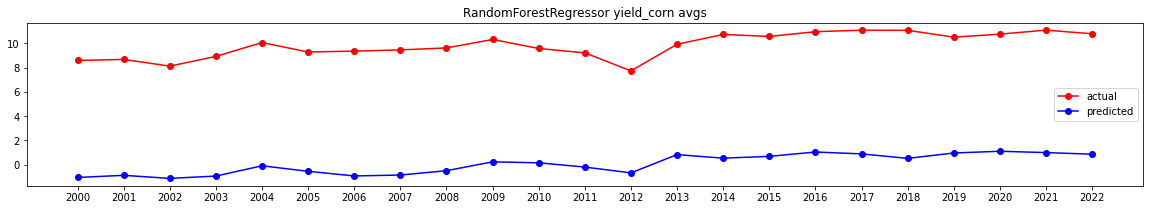

rmse 9.820935928146167
r2 -99.43413631459109


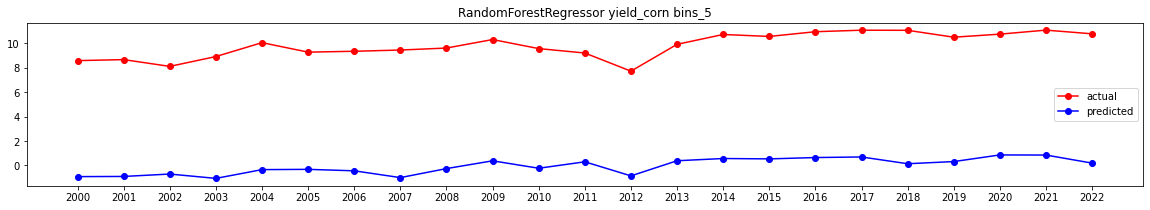

rmse 9.912625980144556
r2 -101.31823347611495


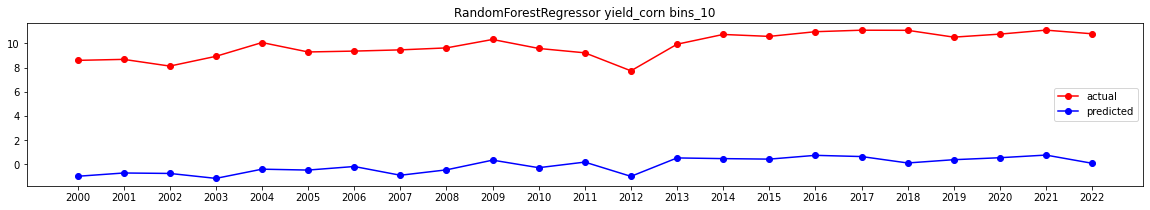

rmse 9.950693144095561
r2 -102.10560179527322


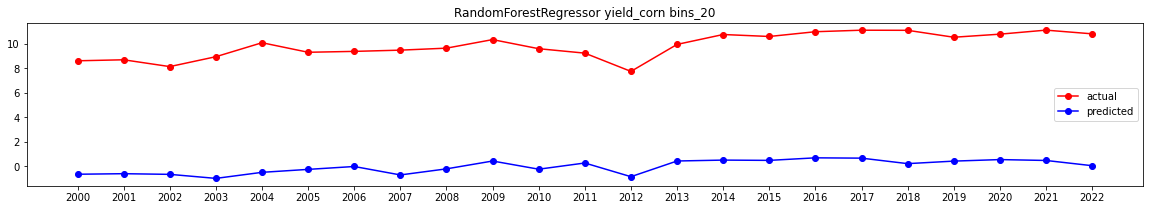

rmse 9.890650213404482
r2 -100.86506814738216


In [151]:
visualize(df_avgs, 'avgs', 'yield_corn', predictions_corn_avgs)
visualize(df_bins_5, 'bins_5', 'yield_corn', predictions_corn_bins_5)
visualize(df_bins_10, 'bins_10', 'yield_corn', predictions_corn_bins_10)
visualize(df_bins_20, 'bins_20', 'yield_corn', predictions_corn_bins_20)

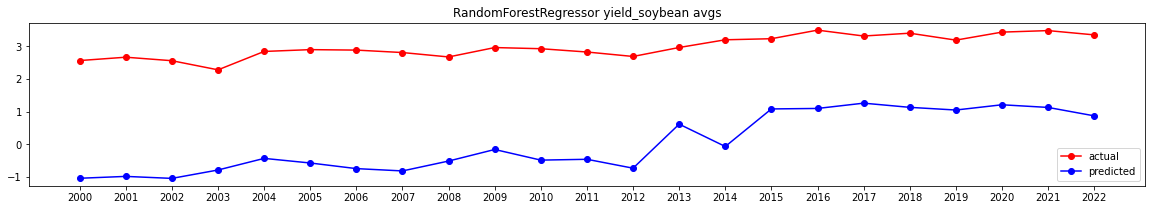

rmse 3.016369521804798
r2 -82.10129983643138


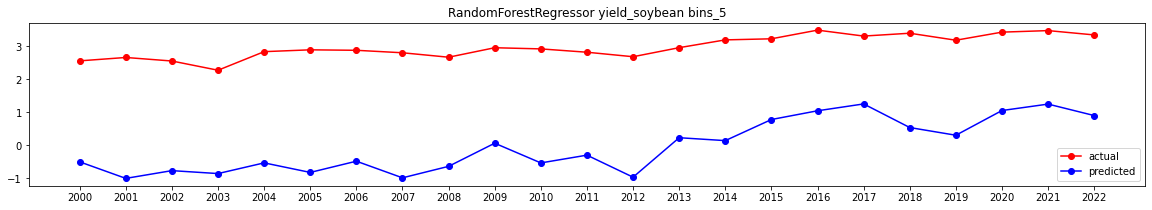

rmse 3.0592649996427395
r2 -84.48165565175826


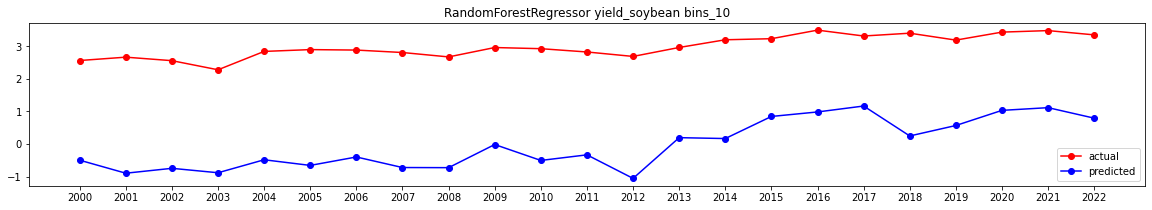

rmse 3.0512039011924967
r2 -84.03176445789683


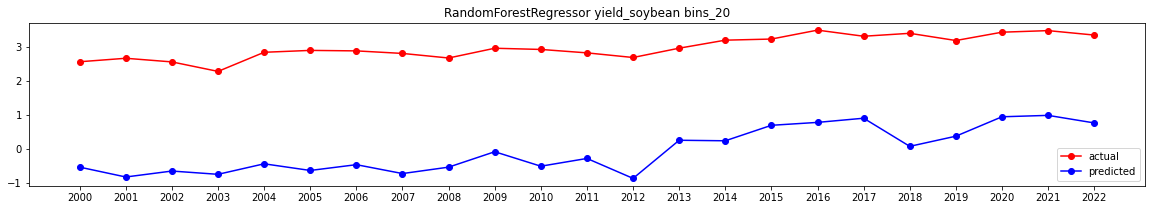

rmse 3.0689825235528354
r2 -85.02557016262071


In [152]:
visualize(df_avgs, 'avgs', 'yield_soybean', predictions_soybean_avgs)
visualize(df_bins_5, 'bins_5', 'yield_soybean', predictions_soybean_bins_5)
visualize(df_bins_10, 'bins_10', 'yield_soybean', predictions_soybean_bins_10)
visualize(df_bins_20, 'bins_20', 'yield_soybean', predictions_soybean_bins_20)

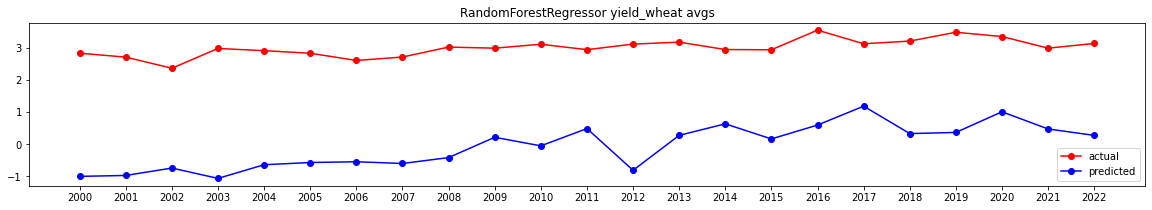

rmse 3.1034852775991624
r2 -138.24403623369275


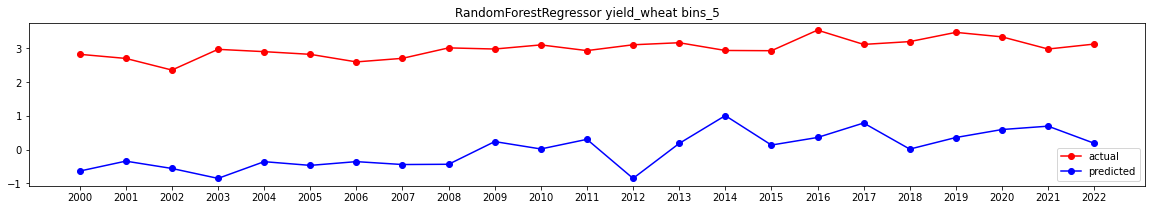

rmse 3.047075413403742
r2 -133.22815797591403


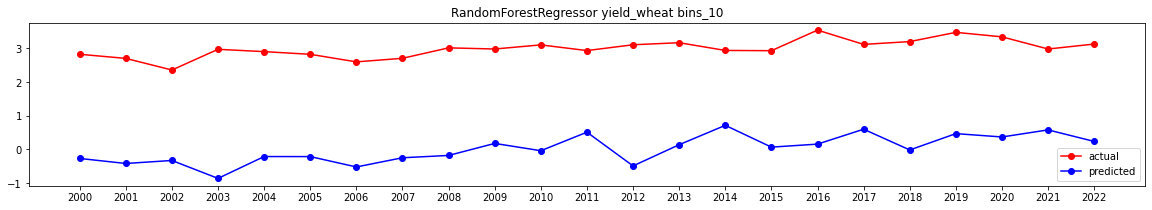

rmse 3.005551825278702
r2 -129.59473442253798


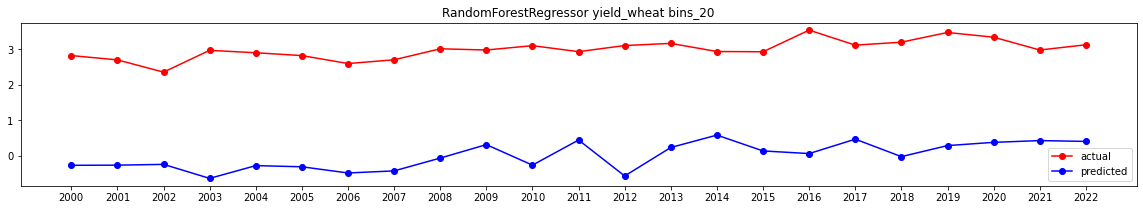

rmse 3.018790193434275
r2 -130.74771316195648


In [153]:
visualize(df_avgs, 'avgs', 'yield_wheat', predictions_wheat_avgs)
visualize(df_bins_5, 'bins_5', 'yield_wheat', predictions_wheat_bins_5)
visualize(df_bins_10, 'bins_10', 'yield_wheat', predictions_wheat_bins_10)
visualize(df_bins_20, 'bins_20', 'yield_wheat', predictions_wheat_bins_20)